In [13]:
from datetime import timedelta
from fuzzywuzzy import fuzz

import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns

import json
import os

from mpl_toolkits.basemap import Basemap 
from matplotlib import cm

获取站点信息，并预处理

In [2]:
r = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')
bikeshare_stations = json.loads(r.content)['data']['stations']
bikeshare_stations = pd.DataFrame(bikeshare_stations)[['station_id', 'name', 'lat', 'lon']].astype({
    'station_id': 'float64',
})

bikeshare_stations.to_csv('./data/bikeshare_stations.csv', index=False)

In [3]:
bikeshare_stations.sample(10)

,station_id,name,lat,lon
24,7026.0,Bay St / St. Joseph St,43.665527,-79.387499
259,7281.0,Charles St W / Balmuto St - SMART,43.668427,-79.387250
220,7241.0,519 Church St - SMART,43.666805,-79.381288
234,7255.0,Stewart St / Bathurst St - SMART,43.643307,-79.402176
344,7378.0,Yonge St / Davisville Ave,43.697597,-79.396540
128,7134.0,Marlborough Ave / Yonge St,43.680000,-79.391111
103,7108.0,Front St E / Cherry St,43.652686,-79.358395
166,7176.0,Bathurst St / Fort York Blvd,43.639179,-79.399595
105,7110.0,Queen St E / Berkeley St,43.655278,-79.365833
6,7007.0,College St / Huron St,43.658148,-79.398167


In [3]:
bikeshare_stations = pd.read_csv('./data/bikeshare_stations.csv')
bikeshare_stations.head()

,station_id,name,lat,lon
0,7000.0,Fort York Blvd / Capreol Crt,43.639832,-79.395954
1,7001.0,Lower Jarvis St / The Esplanade,43.647992,-79.370907
2,7002.0,St. George St / Bloor St W,43.667333,-79.399429
3,7003.0,Madison Ave / Bloor St W,43.667158,-79.402761
4,7004.0,University Ave / Elm St,43.656518,-79.389099


C:\Users\56938\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
C:\Users\56938\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=-79.47657099999999,43.626705,-79.28145500000001,43.7112153&bboxSR=4326&imageSR=4326&size=1500,649&dpi=96&format=png32&transparent=true&f=image


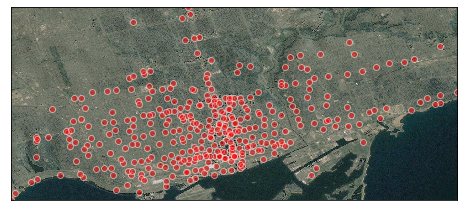

In [22]:
plt.figure(figsize=(8, 8))

# basemap画图
m = Basemap(projection='cyl', resolution='i',
            llcrnrlat = bikeshare_stations['lat'].min(), 
            llcrnrlon = bikeshare_stations['lon'].min(),
            urcrnrlat = bikeshare_stations['lat'].max(), 
            urcrnrlon = bikeshare_stations['lon'].max())
# 加载卫星图
m.arcgisimage(service='ESRI_Imagery_World_2D', 
              xpixels=1500, verbose=True)


for line in bikeshare_stations.iterrows():
    x,y = m(line[1]['lon'],line[1]['lat'])
    plt.plot(x, y, 'o', color='red', alpha=0.5,
             markeredgewidth=1, markeredgecolor='white')
   
plt.show()

ridership：

日期时间格式因文件而异（例如， 31/12/2017 12:30 vs. 12/30/17 12:30:00）

只有Q1和Q2数据包含站ID，第一季度和第二季度的数据在UTC时区（提前4小时），而第三季度和第四季度的数据在东部时区。

车站名称不一致（如Lake Shore Blvd vs. Lakeshore Blvd）

具有相同起点和终点站的行程，表明潜在的数据收集错误

数据清理：

此步骤的目标是将来自多个来源的数据合并到单个数据框中，其中包含标准化的日期和站点信息以及删除的异常值。

官网包含其服务信息的API端点。站点信息可用作某些站点的来源，以解决站ID和名称之间的不一致，并用每个站的额外地理空间信息增强数据特征。

In [4]:
# 录入数据
#      * Key: 文件夹名字
#      * Value: [日期格式, 时区差]

date_formats = {
    'Bikeshare Ridership (2017 Q1).csv': ['%d/%m/%Y %H:%M', -4],
    'Bikeshare Ridership (2017 Q2).csv': ['%d/%m/%Y %H:%M', -4],
    'Bikeshare Ridership (2017 Q3).csv': ['%m/%d/%Y %H:%M', 0],
    'Bikeshare Ridership (2017 Q4).csv': ['%m/%d/%y %H:%M:%S', 0],
}

df = pd.DataFrame() # Initiate an empty DataFrame
for fn, fmt in date_formats.items():
    tmp = pd.read_csv(os.path.join('./data', fn))
    tmp['trip_start_time'] = pd.to_datetime(tmp['trip_start_time'], format=fmt[0], errors='coerce') # 读日期
    tmp['trip_start_time'] = tmp['trip_start_time'] + timedelta(hours=fmt[1])                       # 换时区

    df = pd.concat([df, tmp], sort=False).reset_index(drop=True)                                    # Merge the content of the file to the main DataFrame

In [5]:
df.sample(10)

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_id,from_station_name,to_station_id,to_station_name,user_type
63307,787256,2017-02-17 19:18:00,17/02/2017 23:25,371,7068.0,Dockside Dr / Queens Quay E (Sugar Beach),7168.0,Queens Quay / Yonge St,Member
290070,1051396,2017-05-26 08:59:00,26/05/2017 13:11,695,7055.0,Jarvis St / Carlton St,7005.0,University Ave / King St W,Member
962047,1792313,2017-09-09 18:02:00,9/9/2017 18:29,1639,NaN,Cherry St / Mill St,NaN,Madison Ave / Bloor St W,Member
1067347,1905490,2017-09-22 17:32:00,9/22/2017 17:53,1257,NaN,Adelaide St W / Bay St - SMART,NaN,Fort York Blvd / Capreol Crt,Member
824884,1644137,2017-08-21 20:42:00,8/21/2017 20:54,674,NaN,Beverly St / College St,NaN,Union Station,Member
118288,852836,2017-03-24 09:27:00,24/03/2017 13:34,413,7000.0,Fort York Blvd / Capreol Crt,7052.0,Wellington St W / Bay St,Member
650922,1455319,2017-07-28 07:10:00,7/28/2017 7:21,655,NaN,Dundas St E / Regent Park Blvd,NaN,University Ave / Gerrard St W,Member
1337159,2202079,2017-11-06 16:08:47,11/06/17 16:18:59,612,NaN,Bremner Blvd / Rees St,NaN,Bay St / Albert St,Member
35531,754521,2017-01-27 13:02:00,27/01/2017 17:07,325,7028.0,Gould St / Mutual St,7012.0,Elizabeth St / Edward St (Bus Terminal),Member
123573,859051,2017-03-27 19:28:00,27/03/2017 23:32,227,7118.0,King St W / Bay St (East Side),7033.0,Union Station,Member


In [6]:
stations_start = df[['from_station_id', 'from_station_name']]
stations_end = df[['to_station_id', 'to_station_name']]
stations_start.columns = stations_end.columns = ['station_id', 'name']

# 从“出发站点”和“到达站点”列中提取唯一的站点ID和名称组合
stations = pd.concat([stations_start, stations_end]).dropna(how='all').drop_duplicates().reset_index(drop=True)

In [7]:
stations.sample(10)

,station_id,name
98,7210.0,Mary McCormick Rec Centre (Sheridan Ave)
63,7060.0,Princess St / Adelaide St
140,7103.0,Jimmie Simpson Park (Queen St E)
334,NaN,Dundas St E / Broadview Ave
203,NaN,Bay St / St. Joseph St
152,7111.0,King St W / Douro St
120,7024.0,Dundonald St / Church St
28,7047.0,University Ave / Gerrard St W
261,NaN,Yonge St / Wood St
249,NaN,Parliament St / Aberdeen Ave


具有ID的站点可以从API数据轻松更新，但是没有ID的站点需要一个稍微复杂一些的解决方案。模糊匹配是一种用来识别相似事物的技术（如Yonge St. vs Yonge Street）。在python中有很多模糊匹配字符串的方法，我选择使用fuzzywuzzy库。

In [13]:
# 挑选出没有站点ID的数据
no_ids = stations[stations['station_id'].isnull()]
for idx, miss in no_ids.iterrows():
    max_score = 0
    
    # 比较与站点信息表里各个站点的相似性
    for i, exist in bikeshare_stations[['station_id', 'name']].iterrows():
        score = fuzz.ratio(miss['name'], exist['name'])
        
        if score > 80 and score > max_score:
            max_score = score
            no_ids.at[idx, 'station_id'] = exist['station_id']
    
    # 如果没找到就提示
    if max_score <= 80:
        print('WARN: {0} station could not be matched to an existing station'.format(miss['name']))

# 还没找到就删掉，只留下有ID的
no_ids = no_ids.dropna()

WARN: Michael Sweet Ave / St. Patrick St station could not be matched to an existing station
WARN: Bremner Blvd / Spadina Ave station could not be matched to an existing station
WARN: Bay St / Bloor St W station could not be matched to an existing station
WARN: Bathurst St / Queens Quay W station could not be matched to an existing station
WARN: Wellesley St / Queen's Park Cres station could not be matched to an existing station
WARN: Davenport Rd / Bedford Rd station could not be matched to an existing station
WARN: Victoria St / Gould St (Ryerson University) station could not be matched to an existing station
WARN: Woodbine Subway Green P (Cedarvale Ave) station could not be matched to an existing station
WARN: Stephenson Ave / Main St station could not be matched to an existing station
WARN: Roxton Rd / College St station could not be matched to an existing station
WARN: Base Station station could not be matched to an existing station
WARN: Fringe Next Stage - 7219 station could not

In [14]:
#建立站点表
stations = pd.concat([stations[~stations['station_id'].isnull()], no_ids])\
             .merge(bikeshare_stations[['station_id', 'lat', 'lon']], how='inner', on='station_id')\
             .drop_duplicates()

In [15]:
df = df.merge(stations, how='inner', left_on='from_station_name', right_on='name') \
       .merge(stations, how='inner', left_on='to_station_name', right_on='name', suffixes=['_from', '_to']) \
       .drop_duplicates()
#筛选出需要的列
df = df[[x for x in df.columns if not x.endswith('_station_id') and not x.endswith('_station_name') and x != 'trip_stop_time']]

In [16]:
df.sample(10)

,trip_id,trip_start_time,trip_duration_seconds,user_type,station_id_from,name_from,lat_from,lon_from,station_id_to,name_to,lat_to,lon_to
852165,2111649,2017-10-21 13:11:22,574,Member,7245.0,Tecumseth St / Queen St W - SMART,43.646552,-79.406468,7148.0,King St W / Joe Shuster Way,43.639444,-79.423611
244294,1870736,2017-09-18 22:28:00,463,Member,7257.0,Dundas St W / St. Patrick St,43.654517,-79.389531,7026.0,Bay St / St. Joseph St,43.665527,-79.387499
259945,1661288,2017-08-23 21:02:00,329,Member,7014.0,Sherbourne St / Carlton St (Allan Gardens),43.663102,-79.373181,7164.0,Victoria St / Gould St (Ryerson University),43.657424,-79.381019
1202413,2127648,2017-10-23 15:24:34,957,Member,7031.0,Jarvis St / Isabella St,43.668991,-79.379385,7078.0,College St / Major St,43.657600,-79.403200
718321,1116793,2017-06-07 18:21:00,1117,Member,7060.0,Princess St / Adelaide St,43.652123,-79.367139,7175.0,HTO Park (Queen's Quay W),43.637960,-79.387502
1079668,987815,2017-05-10 19:01:00,1573,Member,7153.0,Bloor St W / Christie St,43.663889,-79.418889,7005.0,University Ave / King St W,43.648093,-79.384749
617004,1610663,2017-08-17 16:01:00,309,Member,7022.0,Simcoe St / Queen St W,43.650858,-79.387582,7033.0,Union Station,43.645609,-79.380386
1384595,2263536,2017-11-20 17:56:43,251,Member,7038.0,Dundas St W / Yonge St,43.656094,-79.381484,7257.0,Dundas St W / St. Patrick St,43.654517,-79.389531
604158,1669431,2017-08-24 19:48:00,382,Member,7047.0,University Ave / Gerrard St W,43.657763,-79.389165,7170.0,Spadina Ave / Willcocks St,43.661667,-79.401389
1216687,1299216,2017-07-07 08:11:00,538,Member,7000.0,Fort York Blvd / Capreol Crt,43.639832,-79.395954,7048.0,Front St W / Yonge St (Hockey Hall of Fame),43.646144,-79.377962


In [17]:
df.describe()

,trip_id,trip_duration_seconds,station_id_from,lat_from,lon_from,station_id_to,lat_to,lon_to
count,1.450091e+06,1.450091e+06,1.450091e+06,1.450091e+06,1.450091e+06,1.450091e+06,1.450091e+06,1.450091e+06
mean,1.548899e+06,1.022822e+03,7.094716e+03,4.365368e+01,-7.939066e+01,7.093837e+03,4.365288e+01,-7.939009e+01
std,4.768715e+05,9.905771e+03,7.635509e+01,1.066515e-02,2.020189e-02,7.612359e+01,1.030869e-02,2.035267e-02
min,7.123820e+05,1.000000e+00,7.000000e+03,4.362671e+01,-7.947657e+01,7.000000e+03,4.362671e+01,-7.947657e+01
25%,1.139838e+06,4.150000e+02,7.032000e+03,4.364561e+01,-7.940146e+01,7.033000e+03,4.364534e+01,-7.939959e+01
50%,1.551459e+06,6.560000e+02,7.068000e+03,4.365278e+01,-7.938758e+01,7.067000e+03,4.365212e+01,-7.938750e+01
75%,1.957884e+06,1.022000e+03,7.158000e+03,4.366180e+01,-7.937990e+01,7.158000e+03,4.366030e+01,-7.937988e+01
max,2.383646e+06,6.382030e+06,7.289000e+03,4.369402e+01,-7.928898e+01,7.289000e+03,4.369402e+01,-7.928898e+01


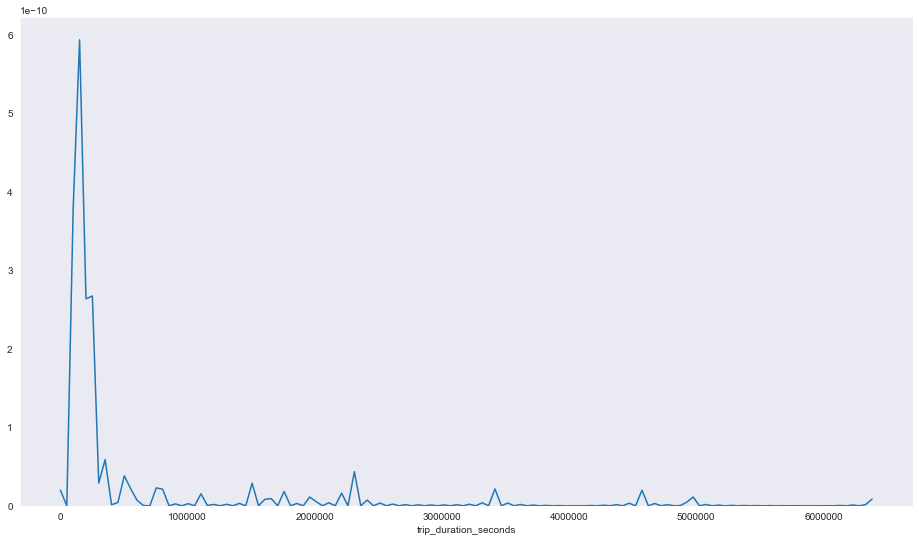

In [19]:
sns.set_style('dark')

fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.distplot(df['trip_duration_seconds'], hist=False, ax=ax)

plt.savefig('./data/raw_distributions.png')

In [20]:
df.shape

(1450091, 12)

In [21]:
#去除不满一分钟的数据
df = df[(df['trip_duration_seconds']>=60)]

In [22]:
df.describe()

,trip_id,trip_duration_seconds,station_id_from,lat_from,lon_from,station_id_to,lat_to,lon_to
count,1.420496e+06,1.420496e+06,1.420496e+06,1.420496e+06,1.420496e+06,1.420496e+06,1.420496e+06,1.420496e+06
mean,1.545266e+06,1.043596e+03,7.094637e+03,4.365372e+01,-7.939065e+01,7.093751e+03,4.365290e+01,-7.939006e+01
std,4.790411e+05,1.000737e+04,7.625829e+01,1.064750e-02,2.014443e-02,7.602921e+01,1.028621e-02,2.029714e-02
min,7.123820e+05,6.000000e+01,7.000000e+03,4.362671e+01,-7.947657e+01,7.000000e+03,4.362671e+01,-7.947657e+01
25%,1.131366e+06,4.290000e+02,7.032000e+03,4.364561e+01,-7.940146e+01,7.033000e+03,4.364561e+01,-7.939959e+01
50%,1.546438e+06,6.670000e+02,7.068000e+03,4.365282e+01,-7.938758e+01,7.067000e+03,4.365212e+01,-7.938750e+01
75%,1.957776e+06,1.033000e+03,7.158000e+03,4.366197e+01,-7.937990e+01,7.158000e+03,4.366030e+01,-7.937988e+01
max,2.383646e+06,6.382030e+06,7.289000e+03,4.369402e+01,-7.928898e+01,7.289000e+03,4.369402e+01,-7.928898e+01


In [23]:
df.shape

(1420496, 12)

我预计大部分的旅行时间不到30分钟。但数据显示，行程持续时间从1到6382030秒（约74天），表明数据中存在异常值。
通常认为不足一分钟的行程是错误的。我取消了这29595次行程，占总行程的2%。
从数据中删除异常值的一种常见统计方法是考虑四分位间距（IQR），即数据的中间50%。离群值定义为距离±1.5*iqr的数据点。我用这个方法删除了一些异常值。

In [24]:
q1 = df['trip_duration_seconds'].quantile(0.25)
q3 = df['trip_duration_seconds'].quantile(0.75)
interquartile_range = q3 - q1

df = df[~((df['trip_duration_seconds'] < (q1 - 1.5 * interquartile_range))|(df['trip_duration_seconds'] > (q3 + 1.5 * interquartile_range)))].reset_index(drop=True)

In [25]:
df.shape

(1338134, 12)

In [26]:
df.to_csv('./data/bikeshare_ridership.csv', index=False)